In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [75]:
gan_df = pd.read_csv('data/generated_data_with_labels_v8.csv')

In [76]:
gan_df.shape

(40000, 47)

In [10]:
# save as csv
df = pd.read_csv('../../data/custom_preprocess_v2_3.csv')

In [11]:
df.shape

(75443, 101)

In [12]:
gan_df.columns

Index(['amount', 'day', 'month', 'year', 'weekofyear', 'is_weekend',
       'day_of_week', 'quarter', 'daily_tx_count_of_recipient',
       'daily_tx_count_of_sender', 'daily_tx_count_of_recipient_accNumber',
       'weekly_tx_count_of_recipient', 'weekly_tx_count_of_sender',
       'weekly_tx_count_of_recipient_accNumber',
       'monthly_tx_count_of_recipient', 'monthly_tx_count_of_sender',
       'monthly_tx_count_of_recipient_accNumber',
       'recipient_acc_per_recipient_name', 'sender_per_recipient_name',
       'weekly_tx_amount_of_recipient', 'weekly_tx_amount_of_sender',
       'weekly_tx_amount_of_recipient_accNumber',
       'monthly_tx_amount_of_recipient', 'monthly_tx_amount_of_sender',
       'monthly_tx_amount_of_recipient_accNumber',
       'daily_tx_amount_of_recipient', 'daily_tx_amount_of_sender',
       'daily_tx_amount_of_recipient_accNumber',
       'weekly_average_tx_amount_of_recipient',
       'weekly_average_tx_amount_of_sender',
       'weekly_average_tx_amo

In [16]:
# rename all columns (except reported) in gan_df to scaled_column_name
scaled_column_names = ['scaled_' + col for col in gan_df.columns if col != 'reported']
gan_df.columns = scaled_column_names + ['reported']

In [18]:
cols = gan_df.columns

In [21]:
# create new merged_df which is a concatenation of df and gan_df
merged_df = pd.concat([df[cols], gan_df[cols]], axis=0)

In [22]:
merged_df.shape

(375443, 47)

## Train the model

In [24]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(46, 23),  # Encode_1: 48 -> 24
            nn.Tanh(),
            nn.Linear(23, 12),  # Encode_2: 24 -> 12
            nn.ReLU(),
            nn.Linear(12, 6),  # Encode_3: 12 -> 6
            nn.LeakyReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),  # Decode_1: 6 -> 12
            nn.Tanh(),
            nn.Linear(12, 23),  # Decode_2: 12 -> 24
            nn.ReLU(),
            nn.Linear(23, 46),  # Decode_3: 24 -> 48
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [26]:
print(merged_df['reported'].value_counts())
print(merged_df['reported'].value_counts(normalize=True))

False    371047
True       4396
Name: reported, dtype: int64
False    0.988291
True     0.011709
Name: reported, dtype: float64


In [47]:
from sklearn.model_selection import train_test_split

input_columns = [col for col in merged_df.columns if col != 'reported']

X = merged_df[input_columns]
y = merged_df['reported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y)

X_normal_train = X_train[y_train == 0]
X_normal_test = X_test[y_test == 0]

In [30]:
train_tensor = torch.tensor(X_normal_train.values, dtype=torch.float32)
test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

batch_size = 64
train_dataset = torch.utils.data.TensorDataset(train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

lambda_reg = 1e-3

# Model initialization
model = Autoencoder()

# Choice of loss
loss_type = 'MSE'  # Choose between 'MSE' and 'BCE'
if loss_type == 'MSE':
    criterion = nn.MSELoss()  # Mean squared error loss
else:
    criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss. Use if you have a sigmoid activation in the output layer.

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=lambda_reg)  #  torch.optim.Adam(model.parameters(), lr=0.001)

# Early stopping setup
best_loss = float('inf')
patience = 10
epochs_without_improvement = 0

# Training loop with early stopping
num_epochs = 100

loss_values = []
test_loss_values = []
reconstruction_errors = []

In [31]:

for epoch in range(num_epochs):
    reconstruction_errors = []
    epoch_loss = 0.0
    for batch in train_dataloader:
        inputs = batch[0]

        # Zero the optimizer's gradient buffer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        mse_loss = criterion(outputs, inputs)
        
        # 3. Activity Regularizer
        # Assuming the first layer of the encoder is model.encoder[0]
        activity_regularizer = lambda_reg * torch.norm(model.encoder[0](inputs), 1)
        
        # Combining the regularized loss
        total_loss = mse_loss + activity_regularizer

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
    
    epoch_loss = epoch_loss / len(train_dataloader)

    # Save the loss value for plotting
    loss_values.append(epoch_loss)

    # Test the model
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for batch in test_dataloader:
            inputs = batch[0]
            outputs = model(inputs)
            mse_loss = criterion(outputs, inputs)
            test_loss += mse_loss.item()

            batch_errors = torch.sum((outputs - inputs) ** 2, dim=1).numpy() # Sum of squared differences for each sample
            reconstruction_errors.extend(batch_errors)

        test_loss = test_loss / len(test_dataloader)
        test_loss_values.append(test_loss)

    model.train()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")


    # Early stopping check
    if epoch_loss + 1e-5 < best_loss:
        best_loss = epoch_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement == patience:
        print("Early stopping due to no improvement in loss.")
        break

Epoch [1/100], Train Loss: 0.0872, Test Loss: 0.0224
Epoch [2/100], Train Loss: 0.0359, Test Loss: 0.0186
Epoch [3/100], Train Loss: 0.0260, Test Loss: 0.0133
Epoch [4/100], Train Loss: 0.0194, Test Loss: 0.0115
Epoch [5/100], Train Loss: 0.0167, Test Loss: 0.0114
Epoch [6/100], Train Loss: 0.0153, Test Loss: 0.0113
Epoch [7/100], Train Loss: 0.0140, Test Loss: 0.0109
Epoch [8/100], Train Loss: 0.0123, Test Loss: 0.0101
Epoch [9/100], Train Loss: 0.0115, Test Loss: 0.0101
Epoch [10/100], Train Loss: 0.0110, Test Loss: 0.0101
Epoch [11/100], Train Loss: 0.0106, Test Loss: 0.0101
Epoch [12/100], Train Loss: 0.0103, Test Loss: 0.0101
Epoch [13/100], Train Loss: 0.0101, Test Loss: 0.0101
Epoch [14/100], Train Loss: 0.0099, Test Loss: 0.0101
Epoch [15/100], Train Loss: 0.0098, Test Loss: 0.0101
Epoch [16/100], Train Loss: 0.0097, Test Loss: 0.0101
Epoch [17/100], Train Loss: 0.0097, Test Loss: 0.0101
Epoch [18/100], Train Loss: 0.0096, Test Loss: 0.0101
Epoch [19/100], Train Loss: 0.0096, T

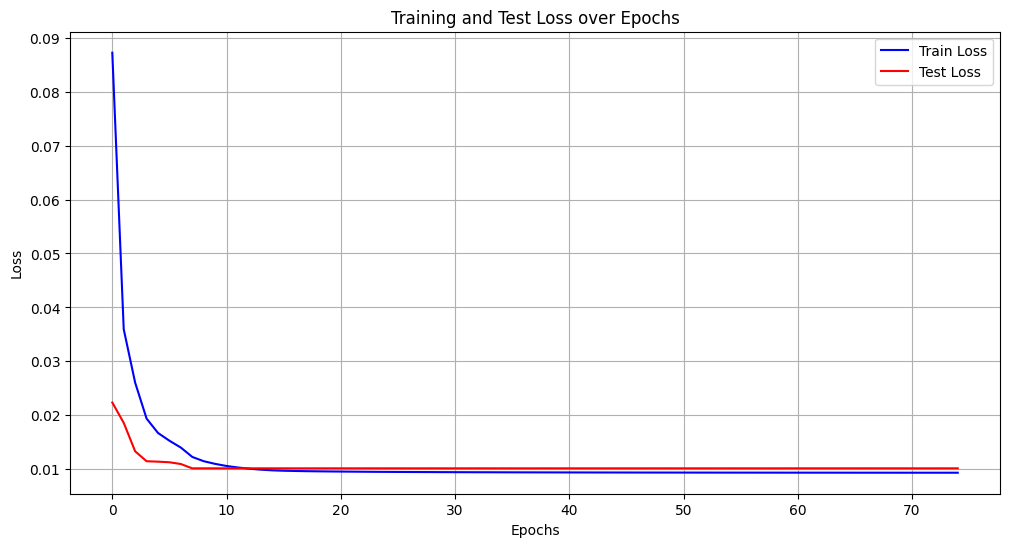

In [33]:
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(loss_values, label="Train Loss", color="blue")
plt.plot(test_loss_values, label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.grid(True)
plt.savefig('../../images/mixed_loss_plot.png')
plt.show()

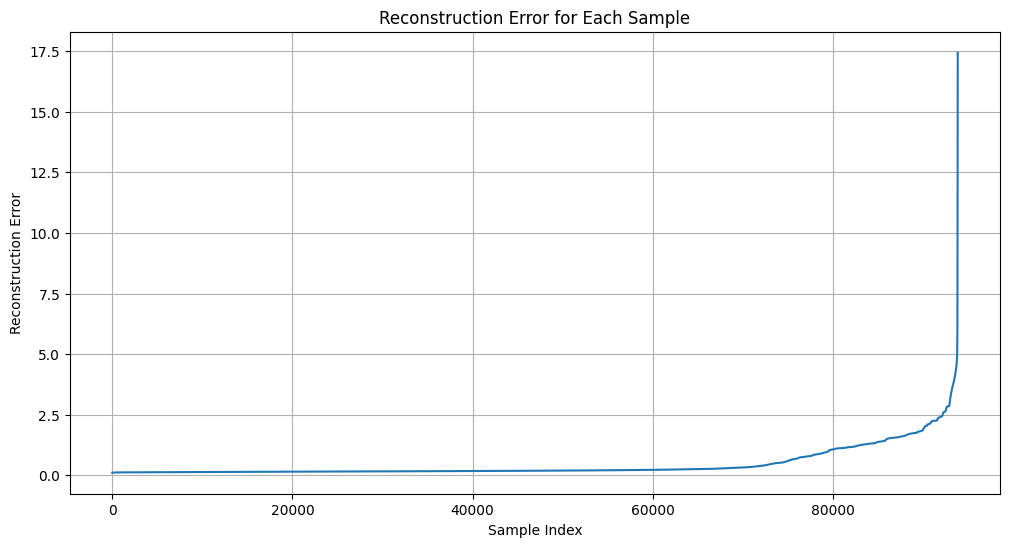

In [34]:
# sort and plot the reconstruction errors
reconstruction_errors.sort()
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors)
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error for Each Sample")
plt.grid(True)

## Evaluations

In [77]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve

# Reconstruct the test data
with torch.no_grad():
    reconstructed_test = model(test_tensor).numpy()

In [78]:
X_test.shape

(93861, 46)

In [70]:
# Calculate reconstruction error
reconstruction_errors = np.mean(np.power(X_test - reconstructed_test, 2), axis=1)

# Choose a threshold based on domain knowledge, the distribution of reconstruction errors, or via a validation set.
threshold = np.percentile(reconstruction_errors, 99)  # e.g., 99th percentile as threshold. This is a naive approach; refine based on your needs.

# Convert reconstruction errors into binary labels (0 or 1)
predicted_labels = [1 if error > threshold else 0 for error in reconstruction_errors]

# Convert reconstruction errors into probabilities between 0 and 1
predicted_probabilities = (reconstruction_errors - min(reconstruction_errors)) / (max(reconstruction_errors) - min(reconstruction_errors))

# Assuming df has a 'reported' column with true labels
true_labels = gan_df['reported'].loc[X_test.index].values

In [71]:
# Calculate metrics
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_probabilities)

# Calculate FPR
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
fpr = fp / (fp + tn)

print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'False Positive Rate (FPR): {fpr:.4f}')

F1 Score: 0.8000
Precision: 0.7987
Recall: 0.8013
Accuracy: 0.9960
ROC AUC: 0.9792
False Positive Rate (FPR): 0.0020


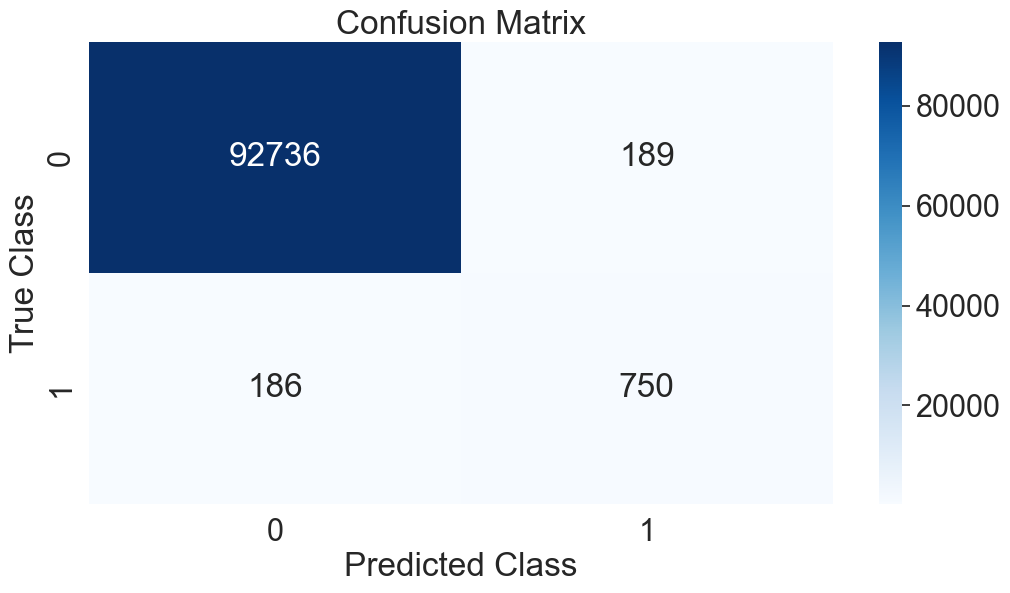

In [74]:
    # heatmap of confusion matrix
import seaborn as sns

sns.set(font_scale=2)  # for label size
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.savefig('../../images/mixed_confusion_matrix.png', bbox_inches='tight')
plt.show()

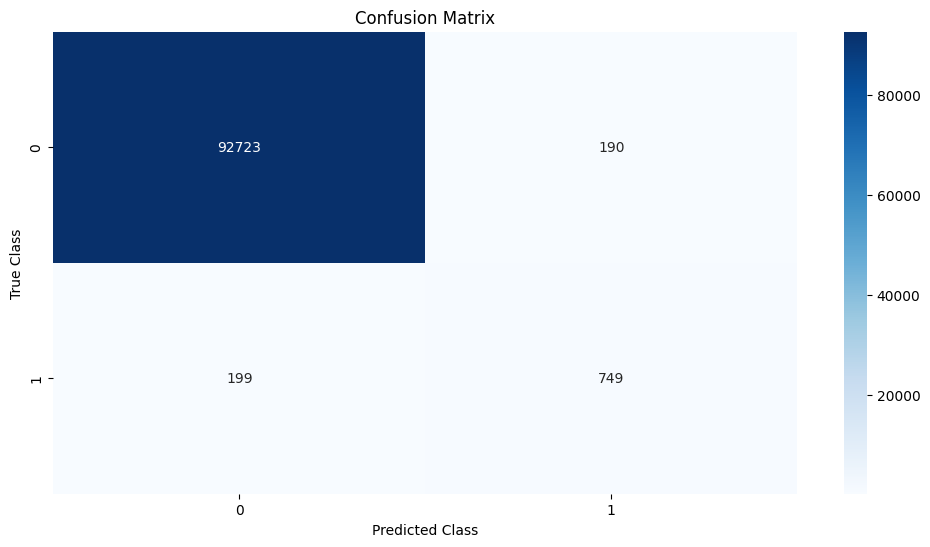

In [41]:
    # heatmap of confusion matrix
import seaborn as sns

sns.set(font_scale=2)  # for label size
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.savefig('../../images/mixed_confusion_matrix.png')
plt.show()

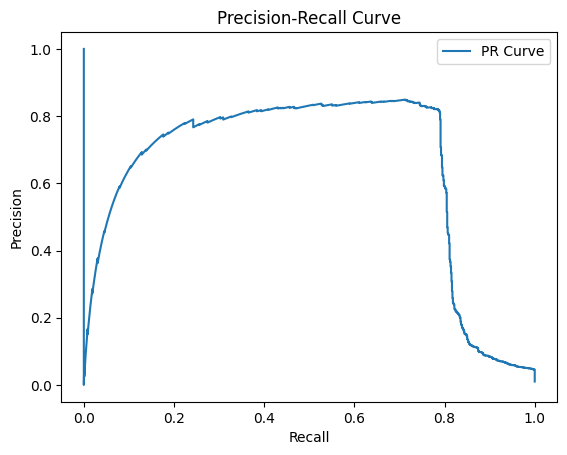

In [42]:
# 1. PR Curve
precision_vals, recall_vals, _ = precision_recall_curve(true_labels, predicted_probabilities)
plt.figure()
plt.plot(recall_vals, precision_vals, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

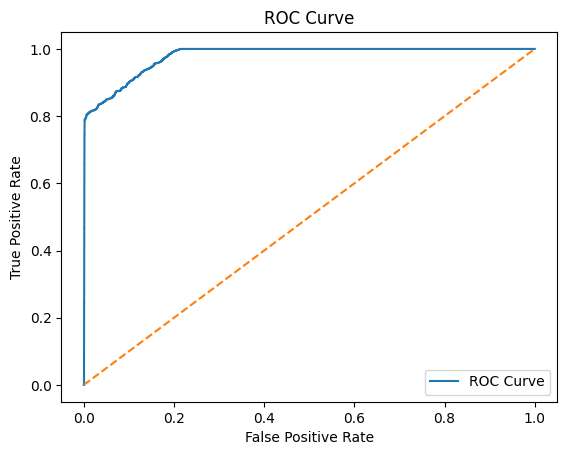

In [43]:
# 2. ROC Curve
fpr_vals, tpr_vals, _ = roc_curve(true_labels, predicted_probabilities)
plt.figure()
plt.plot(fpr_vals, tpr_vals, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

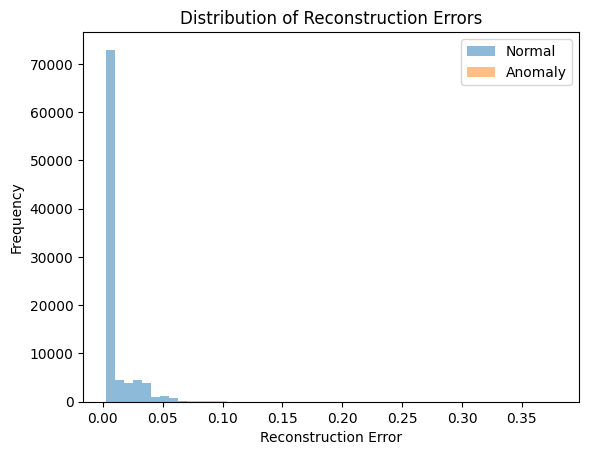

In [44]:
# 3. Distribution of Reconstruction Errors
plt.figure()
plt.hist(reconstruction_errors[true_labels == 0], bins=50, alpha=0.5, label='Normal')
plt.hist(reconstruction_errors[true_labels == 1], bins=50, alpha=0.5, label='Anomaly')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.show()

In [51]:
# calculate mse between test data and reconstructed test data

test_tensor_normal = torch.tensor(X_normal_test.values, dtype=torch.float32)

with torch.no_grad():
    reconstructed_test_normal = model(test_tensor_normal).numpy()

test_reconstruction_errors = np.mean(np.power(X_normal_test - reconstructed_test_normal, 2), axis=1)
# to dataframe
test_reconstruction_errors = pd.DataFrame(test_reconstruction_errors)
test_reconstruction_errors.describe()

,0
count,92762.000000
mean,0.009303
std,0.011740
min,0.002329
25%,0.003400
50%,0.004131
75%,0.006800
max,0.281460


In [55]:
threshold = test_reconstruction_errors.max()[0]
threshold

0.2814604702382396

In [60]:
test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

with torch.no_grad():
    reconstructed_test = model(test_tensor).numpy()

test_reconstruction_errors = np.mean(np.power(X_test - reconstructed_test, 2), axis=1)
# to dataframe
test_reconstruction_errors = pd.DataFrame(test_reconstruction_errors)

In [63]:
# create labels on test data based on threshold and calculate metrics
test_reconstruction_errors['predicted_labels'] = [1 if error > threshold else 0 for error in test_reconstruction_errors[0]]
test_reconstruction_errors['true_labels'] = 1
test_reconstruction_errors['true_labels'].loc[X_normal_test.index] = 0

true_labels = test_reconstruction_errors['true_labels'].values
predicted_labels = test_reconstruction_errors['predicted_labels'].values

# Calculate metrics
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_probabilities)

# Calculate FPR
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
fpr = fp / (fp + tn)

print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'False Positive Rate (FPR): {fpr:.4f}')


F1 Score: 0.0379
Precision: 0.7600
Recall: 0.0194
Accuracy: 0.9897
ROC AUC: 0.4894
False Positive Rate (FPR): 0.0001


/var/folders/l0/myv4vn5x1tq6rttc145y03180000gn/T/ipykernel_12958/1097905966.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_reconstruction_errors['true_labels'].loc[X_normal_test.index] = 0


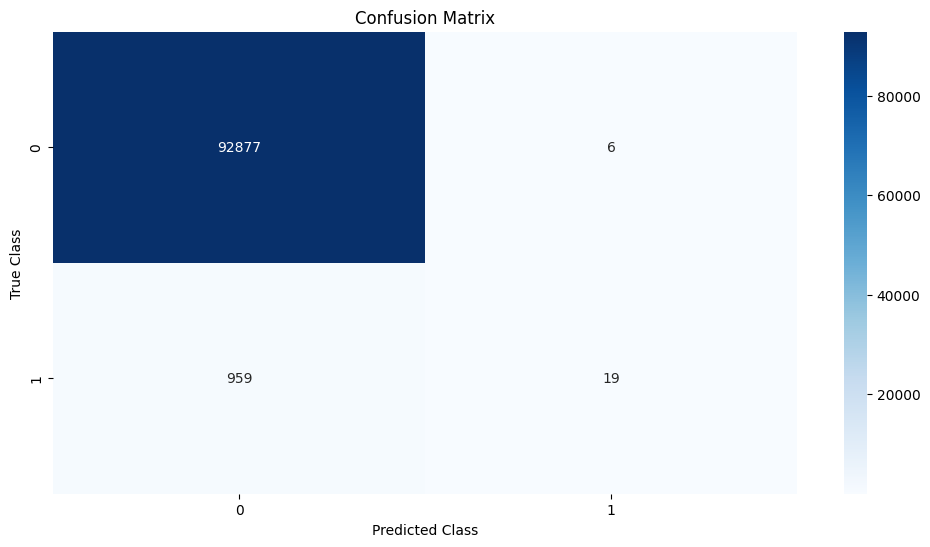

In [66]:
# confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()